In [1]:
from slim_gsgp_lib_np.main_slim import slim
from slim_gsgp_lib_np.utils.utils import train_test_split
from slim_gsgp_lib_np.utils.callbacks import *
from slim_gsgp_lib_np.evaluators.fitness_functions import rmse
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import time
import os
from tqdm import tqdm
from matplotlib import cm
from functions.test_funcs import mape, nrmse, r_squared, mae, standardized_rmse
from matplotlib import pyplot as plt
from slim_gsgp_lib_np.algorithms.SLIM_GSGP.operators.mutators import *
from slim_gsgp_lib_np.algorithms.SLIM_GSGP.operators.simplifiers import *
from slim_gsgp_lib_np.datasets.data_loader import *
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import pdist, squareform
from slim_gsgp_lib_np.selection.selection_algorithms import tournament_selection_min
from slim_gsgp_lib_np.datasets.synthetic_datasets import *

datasets = [globals()[i] for i in globals() if 'load' in i][2:]

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["BLIS_NUM_THREADS"] = "1"

from slim_gsgp_lib_np.main_gp import gp
# from slim_gsgp_lib_np.algorithms.GP.representations.tree import Tree

# -------------------------- # 
from slim_gsgp_lib_np.utils.utils import check_slim_version
from slim_gsgp_lib_np.algorithms.MULTI_SLIM.representations.tree import Tree
from slim_gsgp_lib_np.algorithms.MULTI_SLIM.representations.condition import Condition
from slim_gsgp_lib_np.algorithms.MULTI_SLIM.representations.population import Population    
from slim_gsgp_lib_np.algorithms.MULTI_SLIM.representations.tree_utils import *
from slim_gsgp_lib_np.algorithms.MULTI_SLIM.operators.mutators import *
from slim_gsgp_lib_np.algorithms.MULTI_SLIM.operators.xo import *
from slim_gsgp_lib_np.config.multi_slim_config import SlimParameters, GPParameters
from slim_gsgp_lib_np.main_multi_slim import multi_slim 
from slim_gsgp_lib_np.algorithms.GP.representations.tree import Tree as GP_Tree
from IPython.display import clear_output


Class 1 has 318 samples, and class 2 has 182 samples


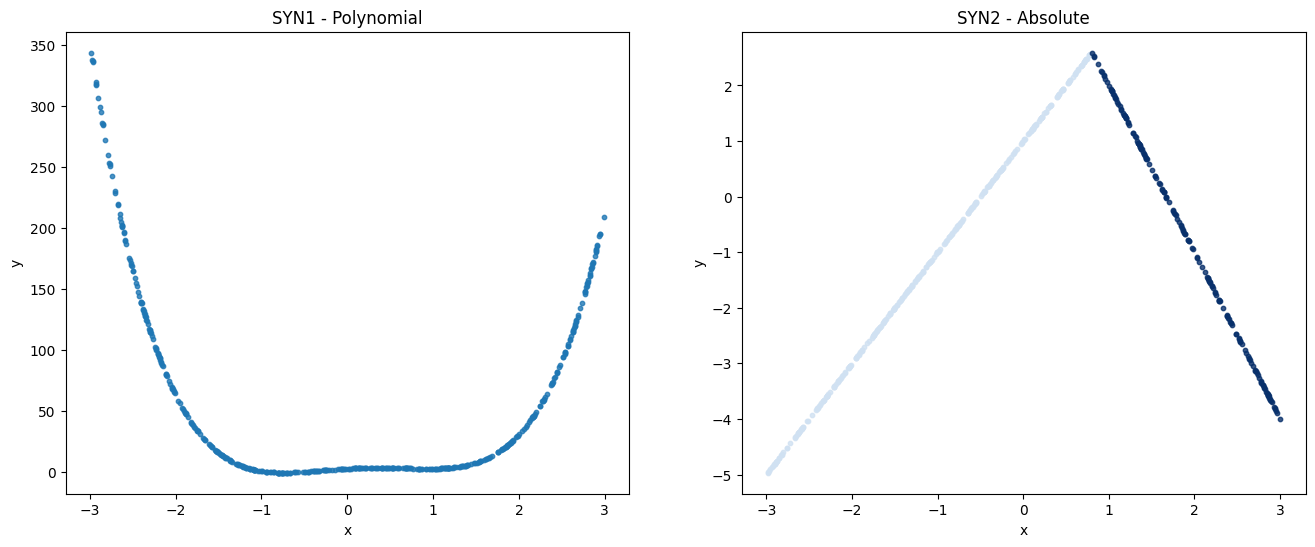

In [ ]:
x1,y1,mask1,mask1 = load_synthetic1(noise=0)
x2, y2, mask2, mask2 = load_synthetic2(noise=0)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].scatter(x1[:, 0], y1, alpha=0.8, s=10, label='x')
axs[0].set_title('SYN1 - Polynomial') 
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')


# Make a nice color palette blue, dark blue, light blue, light green, green, dark green
colors = cm.Blues(np.linspace(0.2, 1, len(mask2)))
for i, submask in enumerate(mask2): 
    axs[1].scatter(x2[submask, 0], y2[submask], alpha=0.8, s=10, label='x', color=colors[i])
axs[1].set_title('SYN2 - Absolute')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
# Show the breakpoints in red

plt.show()

Class 1 has 167 samples, and class 2 has 333 samples
Class distribution:  98 142 135 125


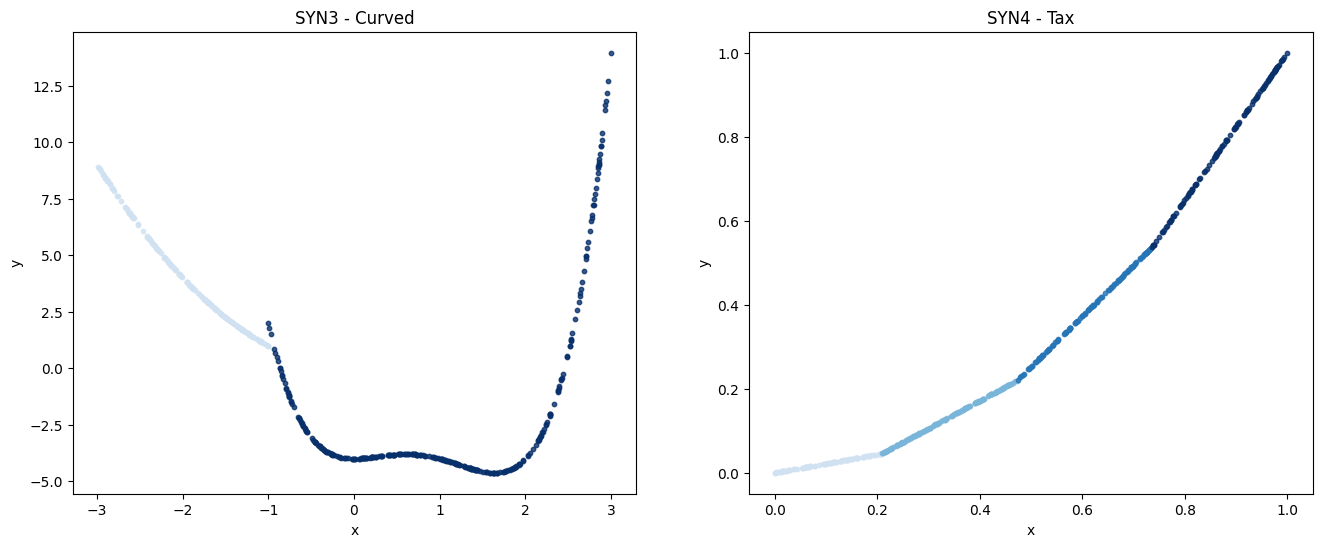

In [ ]:
x3,y3, m3, m3 = load_synthetic3(noise=0)
x4, y4, m4, m4 = load_synthetic4(noise=0)
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

import matplotlib.cm as cm  
colors = cm.Blues(np.linspace(0.2, 1, len(m3)))

for i, submask in enumerate(m3): 
    axs[0].scatter(x3[submask, 0], y3[submask], alpha=0.8, s=10, label='x', color=colors[i])
axs[0].set_title('SYN3 - Curved')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')

colors = cm.Blues(np.linspace(0.2, 1, len(m4)))   

for i, submask in enumerate(m4):
    axs[1].scatter(x4[submask, 0], y4[submask], alpha=0.8, s=10, label='x', color=colors[i])
axs[1].set_title('SYN4 - Tax')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
plt.show()

Class distribution:  285 215


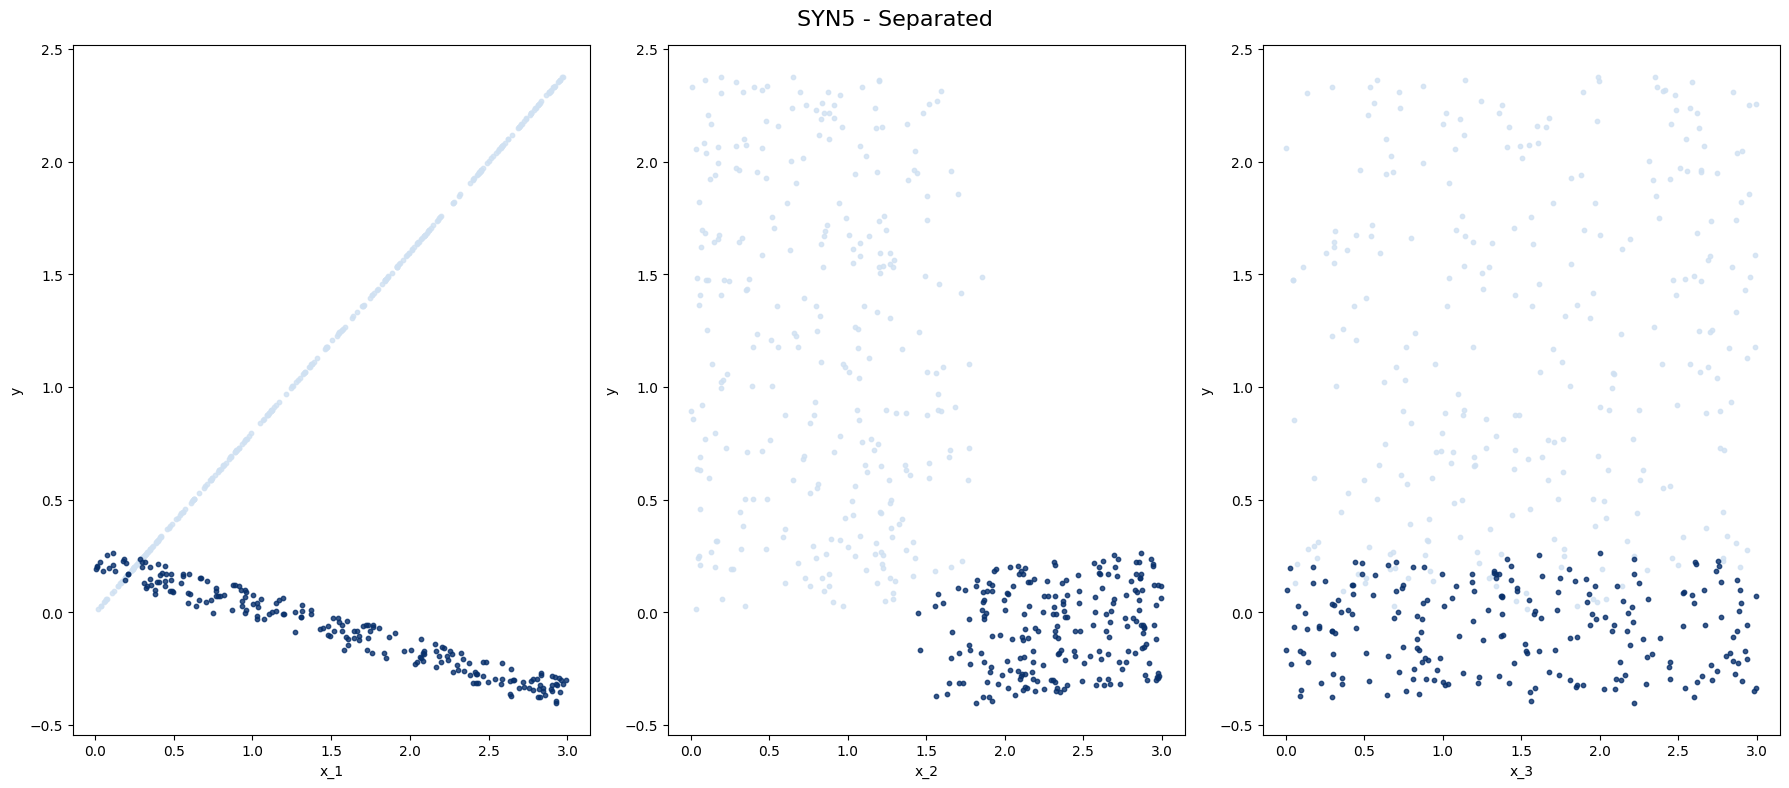

In [ ]:
x5, y5, m5, m5 = load_synthetic5(noise=0)
fig, axs = plt.subplots(1, 3, figsize=(18, 8))
colors = cm.Blues(np.linspace(0.2, 1, len(m5)))

for j in range(3):
    for i, submask in enumerate(m5): 
        axs[j].scatter(x5[submask, j], y5[submask], alpha=0.8, s=10, label='x', color=colors[i])
    axs[j].set_xlabel(f'x_{j+1}')
    axs[j].set_ylabel('y')

# Settittle for the whole figure
plt.suptitle('SYN5 - Separated', fontsize=16)
fig.set_tight_layout(True)  
plt.show()

Class distribution:  84 306 110


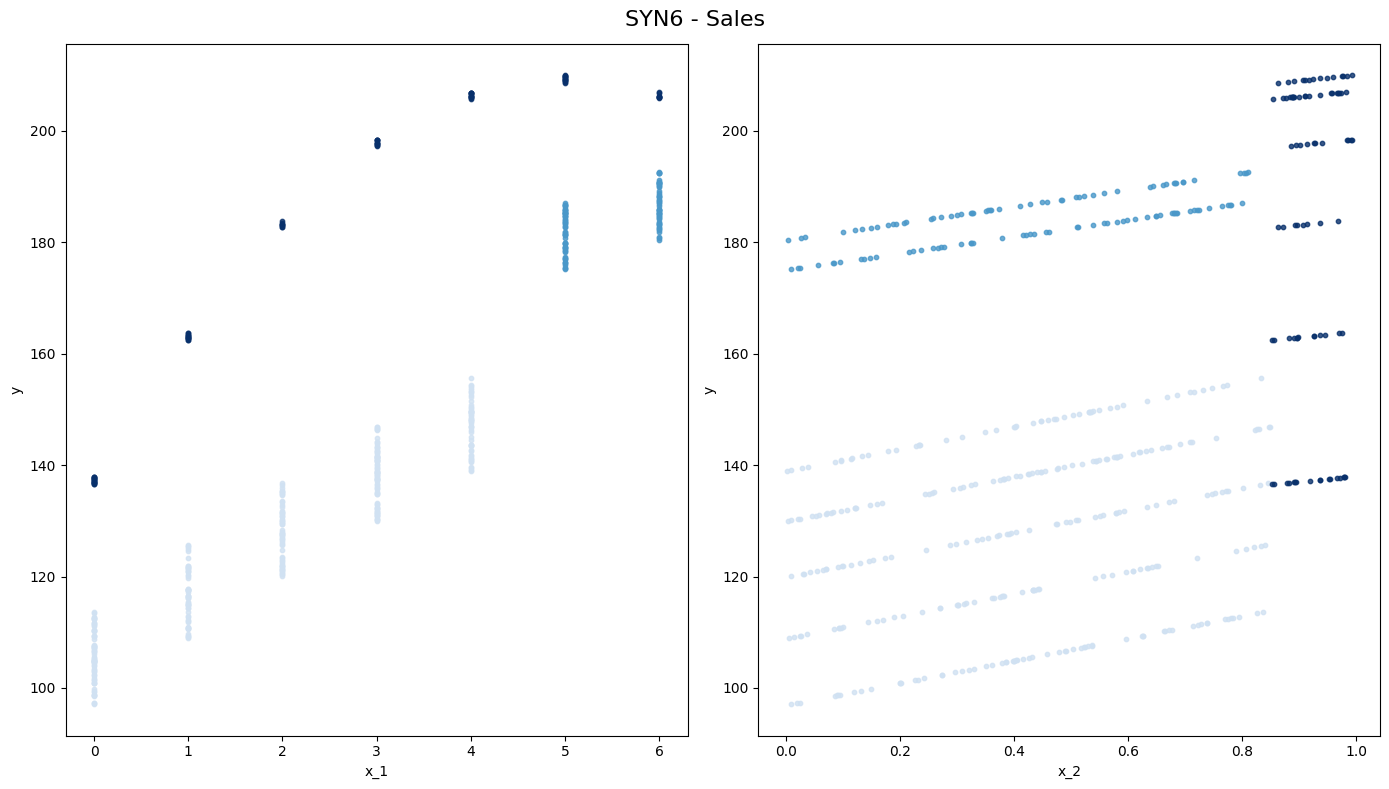

In [ ]:
x6, y6, m6, m6 = load_synthetic6(noise=0)
fig, axs = plt.subplots(1, 2, figsize=(14, 8))
colors = cm.Blues(np.linspace(0.2, 1, len(m6)))

for j in range(2):
    for i, submask in enumerate(m6): 
        axs[j].scatter(x6[submask, j], y6[submask], alpha=0.8, s=10, label='x', color=colors[i])
    axs[j].set_xlabel(f'x_{j+1}')
    axs[j].set_ylabel('y')

# Settittle for the whole figure
plt.suptitle('SYN6 - Sales', fontsize=16)
fig.set_tight_layout(True)  
plt.show()

Mask counts (ABS-elastic, ABS-plastic, Al-elastic, Al-plastic, Steel-elastic, Steel-plastic):
[np.int64(103), np.int64(97), np.int64(97), np.int64(103), np.int64(110), np.int64(90)]


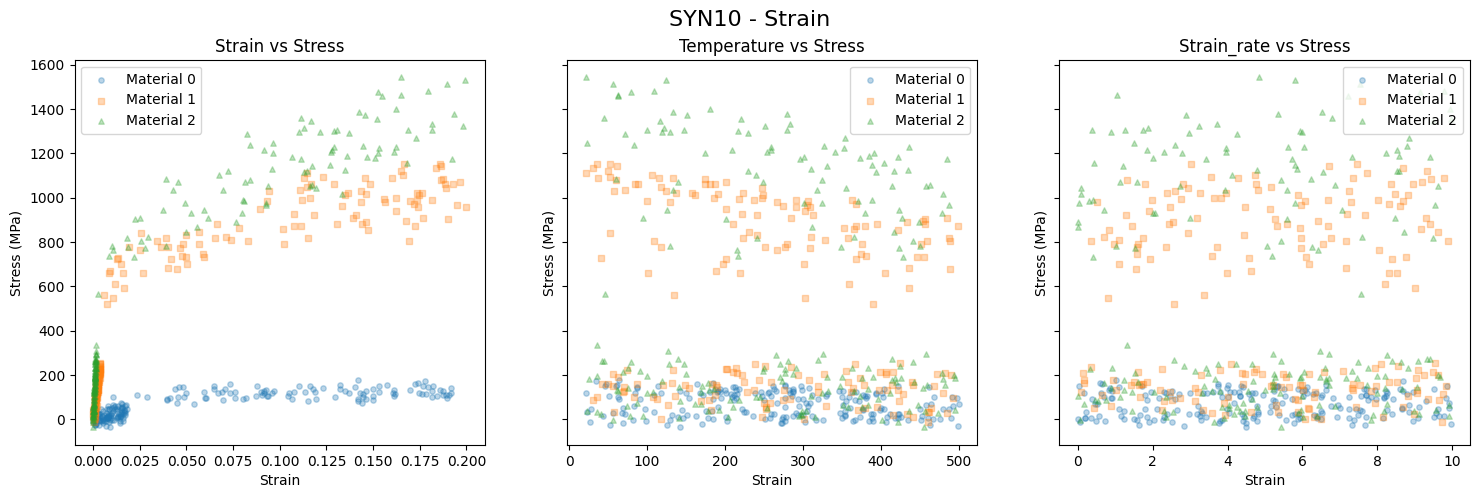

In [ ]:
# Generate and show mask balance
x, y, masks, _ = load_synthetic_10(n=600, seed=42, noise=5)
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
variables = ['Strain', 'Temperature', 'Strain_rate']    
markers = ['o', 's', '^']

for ax_id in range(3):
    for i in range(3): 
        axs[ax_id].scatter(x[x[:,3] == i,ax_id], y[x[:,3] == i], alpha=0.3, s=15, marker=f'{markers[i]}', label=f'Material {i}')
    axs[ax_id].set_xlabel('Strain')
    axs[ax_id].set_ylabel('Stress (MPa)')
    axs[ax_id].set_title(f'{variables[ax_id]} vs Stress')
    axs[ax_id].legend()

# Add a title to the entire figure
fig.suptitle('SYN10 - Strain', fontsize=16)
plt.show()

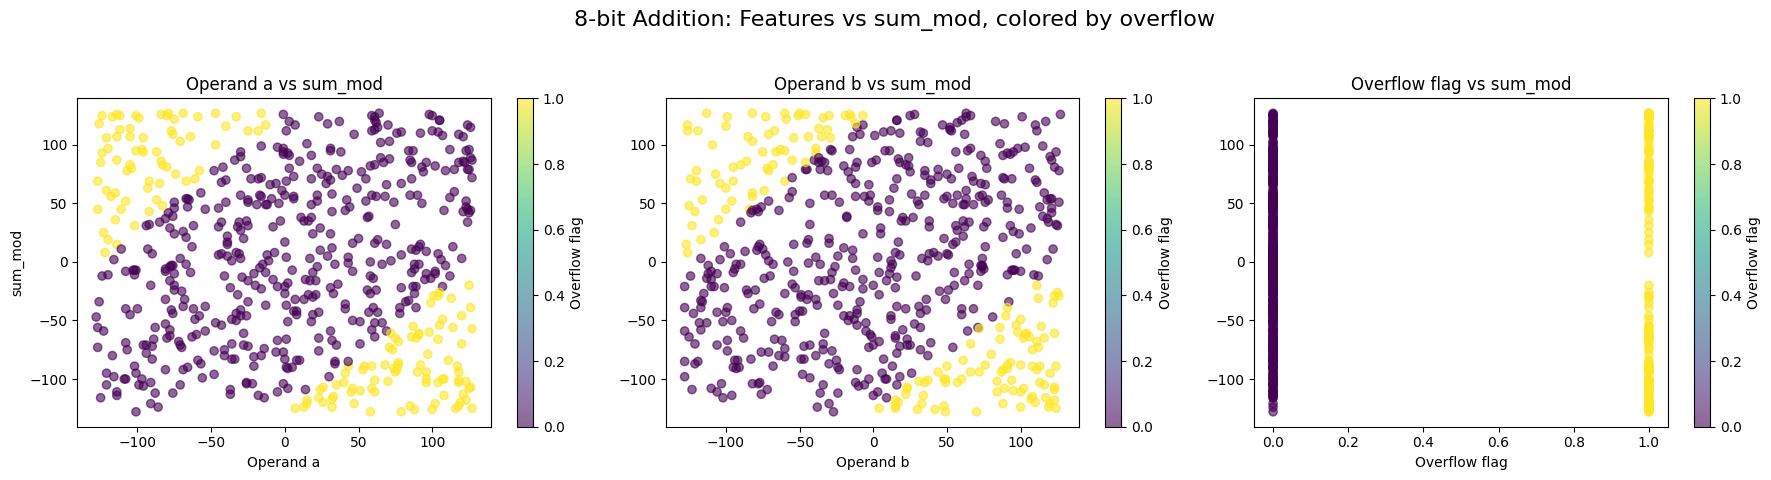

In [ ]:
X, y = load_synthetic_11(n=600, seed=42, noise=0)

# plot each feature vs y, coloring by overflow flag
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
features = ['Operand a', 'Operand b', 'Overflow flag']

for i in range(3):
    sc = axs[i].scatter(X[:, i], y, c=X[:, 2], alpha=0.6)
    axs[i].set_xlabel(features[i])
    if i == 0:
        axs[i].set_ylabel('sum_mod')
    axs[i].set_title(f'{features[i]} vs sum_mod')
    plt.colorbar(sc, ax=axs[i], label='Overflow flag')

fig.suptitle('8-bit Addition: Features vs sum_mod, colored by overflow', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Overflow count distribution:
 wraps=0: 125 samples
 wraps=1: 125 samples
 wraps=2: 125 samples
 wraps=3: 125 samples


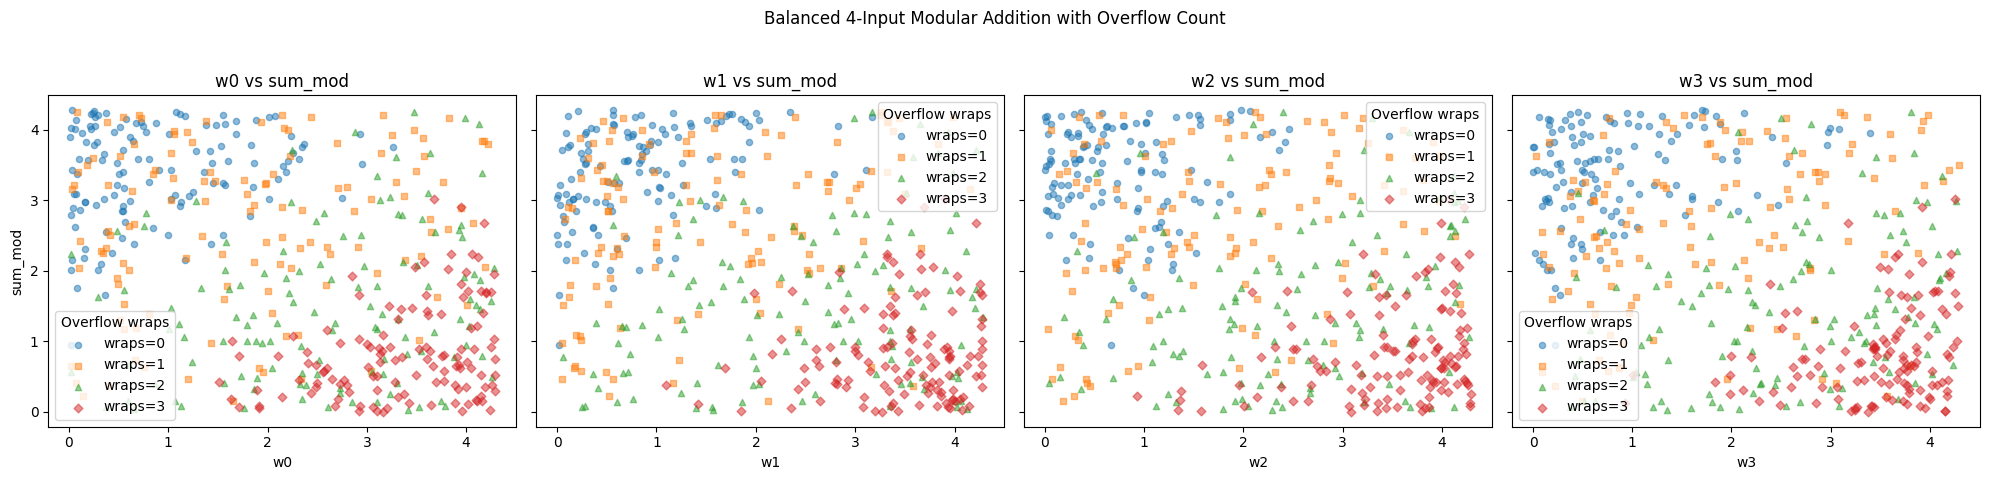

In [ ]:
Xb, yb = load_synthetic_12(n=500, seed=42, balance=True, verbose=True)

fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
labels = ['w0', 'w1', 'w2', 'w3']
markers = ['o', 's', '^', 'D', 'x']
max_wraps = int(Xb[:,4].max())
for i in range(4):
    for wrap in range(max_wraps+1):
        mask = Xb[:,4] == wrap
        axs[i].scatter(Xb[mask, i], yb[mask], alpha=0.5, s=20,
                        marker=markers[wrap % len(markers)],
                        label=f"wraps={wrap}")
    axs[i].set_xlabel(labels[i])
    if i == 0:
        axs[i].set_ylabel('sum_mod')
    axs[i].set_title(f'{labels[i]} vs sum_mod')
    axs[i].legend(title='Overflow wraps')
fig.suptitle('Balanced 4-Input Modular Addition with Overflow Count')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
# # Convert to DataFrame data_usdc and data_usdt
# data_usdc = pd.DataFrame(data_usdc)
# data_usdt = pd.DataFrame(data_usdt)

# # Convert timestamp to datetime
# data_usdc['t'] = pd.to_datetime(data_usdc['t'], unit='s')
# data_usdt['t'] = pd.to_datetime(data_usdt['t'], unit='s')

# # Set the timestamp as the index
# data_usdc.set_index('t', inplace=True)
# data_usdt.set_index('t', inplace=True)

# # Resample to daily frequency and sum the values
# data_usdc_daily = data_usdc.resample('D').sum()
# data_usdt_daily = data_usdt.resample('D').sum()

# # Merge the two DataFrames on the index (timestamp)
# merged_data = pd.merge(data_usdc_daily, data_usdt_daily, left_index=True, right_index=True, suffixes=('_usdc', '_usdt'))

# # Rename columns for clarity
# merged_data.columns = ['USDC', 'USDT']
# merged_data['Total'] = merged_data['USDC'] + merged_data['USDT']
# merged_data

# # Now convert to weekly values 
# merged_data_weekly = merged_data.resample('W').mean()
# merged_data_stable = merged_data_weekly.copy()


sp500 = pd.read_csv('sp500.csv')
sent1 = pd.read_csv('sent1.csv')
sent2 = pd.read_csv('sent2.csv')    
btcusdt = pd.read_csv('btcusdt.csv')

# ------------------------------ SP500 --------------------------------
sp500['Date'] = pd.to_datetime(sp500['Date'])
sp500.set_index('Date', inplace=True)
# Resample to weekly frequency. The open should be the first value of the week and the close the last value of the week
sp500 = sp500.resample('W').agg({'Open': 'first', 'Close/Last': 'last', 'High': 'max', 'Low': 'min'})
sp500 = sp500.iloc[:-1]
sp500['chg_sp'] = sp500['Close/Last'].pct_change()
sp500.dropna(inplace=True)

# The values should be presented one week later
sp500.index = pd.to_datetime(sp500.index) + pd.DateOffset(weeks=1)
sp500['chg_sp(10)'] = (1 + sp500['chg_sp']).rolling(window=10).apply(np.prod, raw=True) - 1
sp500.dropna(inplace=True)
sp500.drop(columns=['Close/Last', 'Open', 'High', 'Low'], inplace=True)
# --------------------------- Sentiments ---------------------------
sent1 = sent1.iloc[1:]
sent1.reset_index(inplace=True)
sent1.columns = ['Date', 'Sentiment']
sent1.set_index('Date', inplace=True)
sent1['Sentiment'] = sent1['Sentiment'].astype(float)
sent1['per_change'] = sent1['Sentiment'].pct_change()
sent1.dropna(inplace=True)  

sent2 = sent2.iloc[1:]
sent2.reset_index(inplace=True)
sent2.columns = ['Date', 'Sentiment']
sent2.set_index('Date', inplace=True)
sent2['Sentiment'] = sent2['Sentiment'].astype(float)
sent2['per_change'] = sent2['Sentiment'].pct_change()
sent2.dropna(inplace=True)

# Merge the two sentiment DataFrames. If there is overlap, keep the first one
sentiment = pd.merge(sent1, sent2, left_index=True, right_index=True, suffixes=('_sent1', '_sent2'), how='outer')

# create a column that is the mean of the two sentiments
sentiment['chg_sen'] = sentiment[['per_change_sent1', 'per_change_sent2']].mean(axis=1)
sentiment = sentiment[['chg_sen']].copy()

# The values should be presented one week later 
sentiment.index = pd.to_datetime(sentiment.index) + pd.DateOffset(weeks=1)
sentiment['chg_sen(10)'] = (1 + sentiment['chg_sen']).rolling(window=10).apply(np.prod, raw=True) - 1

# -------------------------- BTCUSDT --------------------------
btcusdt.reset_index(inplace=True)
btcusdt = btcusdt.iloc[1:]
btcusdt.columns = ['Unix', 'Date', 'Symbol', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume USDT', 'Tradecount']
btcusdt = btcusdt[['Date', 'Open', 'High', 'Low', 'Close', 'Volume USDT', 'Tradecount']].copy()
btcusdt['Date'] = pd.to_datetime(btcusdt['Date'])  
btcusdt.set_index('Date', inplace=True) 
btcusdt = btcusdt.astype(float)
btc_wk = btcusdt.resample('W').agg({'Open': 'first', 'Close': 'last', 'High': 'max', 'Low': 'min', 'Volume USDT': 'sum', 'Tradecount': 'sum'})
btc_wk = btc_wk.iloc[:-1]
btc_wk['change'] = btc_wk['Close'].pct_change()
btc_wk.dropna(inplace=True)

y = btc_wk['change'].copy()

btc_wk['candle_size'] = (btc_wk['High'] - btc_wk['Low']) / btc_wk['Open']
btc_wk['std (10)'] = btc_wk['Close'].rolling(window=10).std() / btc_wk['Close'].rolling(window=10).mean()
btc_wk['vol_relative'] = btc_wk['Volume USDT'] / btc_wk['Volume USDT'].rolling(window=20).mean()
btc_wk['tcount_rel'] = btc_wk['Tradecount'] / btc_wk['Tradecount'].rolling(window=20).mean()


# MAke the values one week later
btc_wk.index = pd.to_datetime(btc_wk.index) + pd.DateOffset(weeks=1)
btc_wk.dropna(inplace=True)

# The rest of the indicators 
btc_wk = btc_wk[['vol_relative', 'candle_size', 'tcount_rel', 'std (10)', 'change']].copy().iloc[:-1]
btc_wk['change (-1)'] = btc_wk['change']
btc_wk.drop(columns=['change'], inplace=True)
btc_wk['change (-2)'] = btc_wk['change (-1)'].shift(1)
btc_wk['change (-3)'] = btc_wk['change (-1)'].shift(2)
btc_wk['change (-4)'] = btc_wk['change (-1)'].shift(3)
btc_wk['change (-5)'] = btc_wk['change (-1)'].shift(4)
btc_wk.dropna(inplace=True)

# ------------------- STABLE ----------------------------
# Aggregate the data 
stable = merged_data_stable[['Total']].copy()
stable['chg_stb'] = stable['Total'].pct_change()
# Advance one week 
stable.index = pd.to_datetime(stable.index) + pd.DateOffset(weeks=1)
stable.dropna(inplace=True)
stable.drop(columns=['Total'], inplace=True)    

df = pd.merge(stable, sp500, left_index=True, right_index=True, how='outer')
df = pd.merge(df, sentiment, left_index=True, right_index=True, how='outer')
df = pd.merge(df, btc_wk, left_index=True, right_index=True, how='outer')
df.dropna(inplace=True)
df